1. Import and Install Dependencies

1.1 Install Dependencies

In [ ]:
%pip install tensorflow matplotlib tensorflow-io

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
from sklearn import preprocessing
import random as rn
from keras.layers import Dense
from keras import Input
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
import tensorflow as tf
import random

2023-11-22 16:31:32.170319: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 16:31:33.421334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2. Data Loading

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-11-22 16:31:37.522752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 16:31:37.914193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 16:31:37.914252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-11-22 16:31:38.071075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 16:31:38.071202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 16:31:38.071241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 16:31:40.202277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 16:31:40.202304: I tensorflow/core/co

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
DATA_DIR = os.path.join('data', 'train/')
def get_data_dir(label):
    return os.path.join('data', 'train2', label, '/')

In [7]:
check_dir = os.path.join('data', 'train/')

wav, sr = librosa.load(check_dir + 'Q-01.wav', sr=16000)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 16000
wav shape: (7040,)
length: 0.44 secs


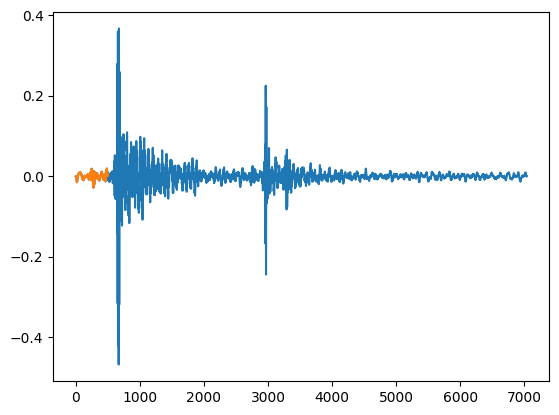

In [8]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [9]:
train_mlp = []
train_spectrograms = []
train_mel_spectrograms = []
train_mfccs = []
train_y = []

test_mlp = []
test_spectrograms = []
test_mel_spectrograms = []
test_mfccs = []
test_y = []

# 모든 음성파일의 길이가 같도록 후위에 padding 처리
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

frame_length = 0.025
frame_stride = 0.0010

In [10]:
from sklearn.model_selection import train_test_split

Spectogram and binary classification by each label

In [11]:
def get_spectrogram(filename):
    wav, sr = librosa.load(filename, sr=16000)
    spectrogram = np.abs(librosa.stft(wav))
    padded_spectrogram = pad2d(spectrogram, 40)
    return padded_spectrogram

In [15]:
def create_binary_class_model(key):
    X = []
    y = []
    
    data_dir = os.path.join('data', 'train/')
    for filename in os.listdir(data_dir):
        if '.wav' not in filename:
            continue

        spectrogram = get_spectrogram(data_dir + filename)
        label = 1 if key == filename[0] else 0  # 'Q' is 1, 'not Q' is 0

        X.append(spectrogram)
        y.append(label)

    train_spectrograms, test_spectrograms, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

    train_spectrograms = np.array(train_spectrograms)
    train_y = np.array(train_y)  

    test_spectrograms = np.array(test_spectrograms)
    test_y = np.array(test_y)  

    print('train_mfccs:', train_spectrograms.shape)
    print('train_y:', train_y.shape)

    print('test_mfccs:', test_spectrograms.shape)
    print('test_y:', test_y.shape)
    train_spectrograms = np.expand_dims(train_spectrograms, -1)
    test_spectrograms = np.expand_dims(test_spectrograms, -1)
    print('train_spectograms shape:', train_spectrograms.shape)
    print('test_spectograms shape:', test_spectrograms.shape)
    ip = Input(shape=train_spectrograms[0].shape)

    m = Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
    m = MaxPooling2D(pool_size=(4,4))(m)

    m = Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
    m = MaxPooling2D(pool_size=(4,4))(m)

    m = Conv2D(32 * 3, kernel_size=(4, 4), activation='relu')(ip)
    m = MaxPooling2D(pool_size=(4,4))(m)

    m = Flatten()(m)

    m = Dense(64, activation='relu')(m)

    m = Dense(32, activation='relu')(m)

    op = Dense(1, activation='sigmoid')(m) 

    model = Model(ip, op)

    model.summary()

    model.compile(loss='binary_crossentropy',  
                optimizer='adam',
                metrics=['accuracy'])

    history = model.fit(train_spectrograms,
                        train_y,
                        epochs=100,
                        batch_size=32,
                        verbose=1,
                        validation_data=(test_spectrograms, test_y))
    return model, history

Q

In [16]:
Q_model, Q_history = create_binary_class_model('Q')

train_mfccs: (1184, 1025, 40)
train_y: (1184,)
test_mfccs: (296, 1025, 40)
test_y: (296,)
train_spectograms shape: (1184, 1025, 40, 1)
test_spectograms shape: (296, 1025, 40, 1)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1025, 40, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 1022, 37, 96)      1632      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 255, 9, 96)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 220320)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                14100544  
             

2023-11-22 16:42:27.853597: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 194176000 exceeds 10% of free system memory.
2023-11-22 16:42:28.008255: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 194176000 exceeds 10% of free system memory.


37/37 [==============================] - 3s 48ms/step - loss: 0.2782 - accuracy: 0.9003 - val_loss: 0.0474 - val_accuracy: 0.9865
Epoch 2/100
37/37 [==============================] - 2s 43ms/step - loss: 0.0115 - accuracy: 0.9992 - val_loss: 0.0064 - val_accuracy: 0.9966
Epoch 3/100
37/37 [==============================] - 2s 42ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9966
Epoch 4/100
37/37 [==============================] - 2s 42ms/step - loss: 8.6049e-04 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 5/100
37/37 [==============================] - 2s 41ms/step - loss: 5.5149e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 6/100
37/37 [==============================] - 2s 42ms/step - loss: 3.3785e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/100
37/37 [==============================] - 2s 42ms/step - loss: 2.1727e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Ep

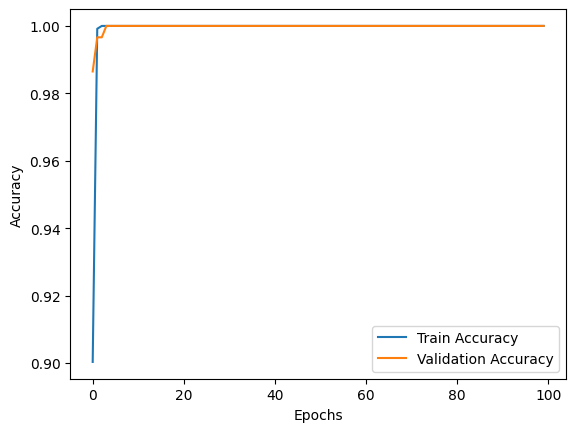

In [17]:
plt.plot(Q_history.history['accuracy'], label='Train Accuracy')
plt.plot(Q_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Text(0, 0.5, 'Accuracy [%]')

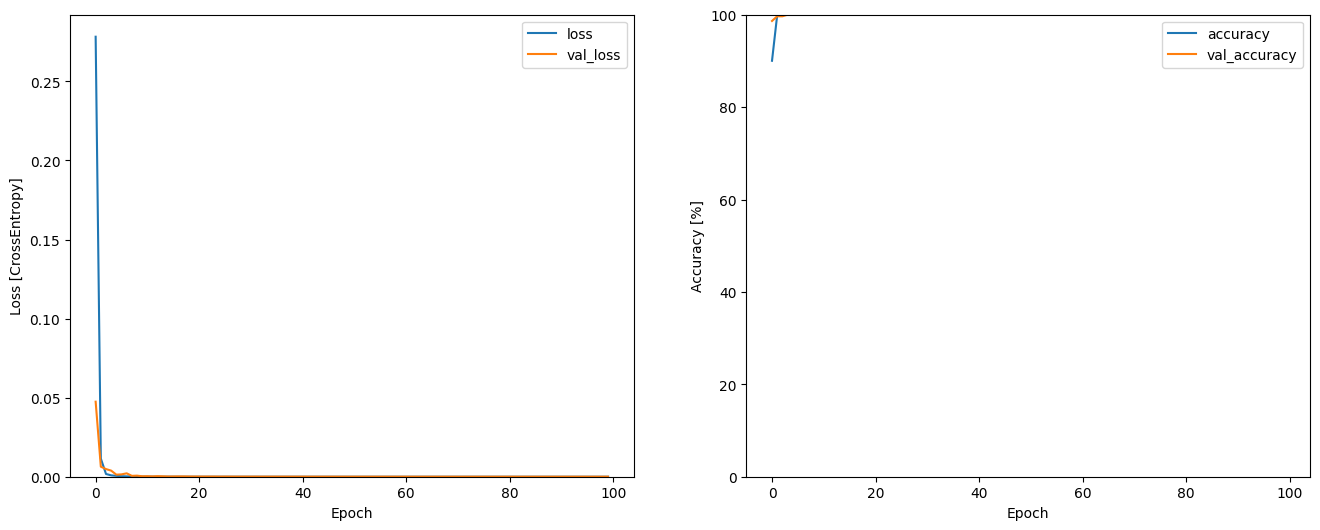

In [18]:
metrics = Q_history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(Q_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(Q_history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [62]:
import random

def test_random_file():
    key = random.choice(['Q', 'W', 'E', 'R'])
    number = random.randint(0, 200)
    filename = f"{DATA_DIR}{key}-{number}.wav"

    try:
        spectrogram = get_spectrogram(filename)
    except FileNotFoundError:
        print(f"The file '{filename}' does not exist.")
        return

    spectrogram = np.expand_dims(spectrogram, 0)
    prediction = Q_model.predict(spectrogram)
    is_q = prediction[0] > 0.5

    print(f"The input file is '{filename}' and this is {'Q' if is_q else 'not Q'}.")
    print(f"The model thinks it has {prediction[0][0]*100:.2f}%  chacne of being Q.")

# Call the function to test a random file
test_random_file()

1/1 [==============================] - 0s 18ms/step
The input file is 'data/train/E-142.wav' and this is not Q.
The model thinks it has 0.00%  chacne of being Q.


In [ ]:
model.save('/home/hyochung/Keyboard_DL') #save mdoel

In [31]:
R_model, R_history = create_binary_class_model('R')

train_mfccs: (1184, 1025, 40)
train_y: (1184,)
test_mfccs: (296, 1025, 40)
test_y: (296,)
train_spectograms shape: (1184, 1025, 40, 1)
test_spectograms shape: (296, 1025, 40, 1)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1025, 40, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 1022, 37, 96)      1632      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 255, 9, 96)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 220320)            0         
                                                                 
 dense_6 (Dense)             (None, 64)                14100544  
             

2023-11-22 17:20:06.892184: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 194176000 exceeds 10% of free system memory.


37/37 [==============================] - 3s 51ms/step - loss: 0.2824 - accuracy: 0.8826 - val_loss: 0.1079 - val_accuracy: 0.9831
Epoch 2/100
37/37 [==============================] - 2s 45ms/step - loss: 0.0392 - accuracy: 0.9899 - val_loss: 0.0888 - val_accuracy: 0.9932
Epoch 3/100
37/37 [==============================] - 2s 44ms/step - loss: 0.0093 - accuracy: 0.9966 - val_loss: 0.0885 - val_accuracy: 0.9966
Epoch 4/100
37/37 [==============================] - 2s 44ms/step - loss: 0.0066 - accuracy: 0.9992 - val_loss: 0.1173 - val_accuracy: 0.9932
Epoch 5/100
37/37 [==============================] - 2s 44ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.0989 - val_accuracy: 0.9966
Epoch 6/100
37/37 [==============================] - 2s 44ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.1132 - val_accuracy: 0.9966
Epoch 7/100
37/37 [==============================] - 2s 44ms/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.1380 - val_accuracy: 0.9966
Epoch 8/100
37/37 

In [61]:
def test_random_file():
    key = random.choice(['Q', 'W', 'E', 'R'])
    number = random.randint(0, 200)
    filename = f"{DATA_DIR}{key}-{number}.wav"

    try:
        spectrogram = get_spectrogram(filename)
    except FileNotFoundError:
        print(f"The file '{filename}' does not exist.")
        return

    spectrogram = np.expand_dims(spectrogram, 0)
    prediction = R_model.predict(spectrogram)
    is_q = prediction[0] > 0.5

    print(f"The input file is '{filename}' and this is {'R' if is_q else 'not R'}.")
    print(f"The model thinks it has {prediction[0][0]*100:.2f}%  chacne of being R.")
# Call the function to test a random file
test_random_file()

1/1 [==============================] - 0s 38ms/step
The input file is 'data/train/R-137.wav' and this is R.
The model thinks it has 100.00%  chacne of being R.
